Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**

# **CNN**

El objetivo de este *notebook* es introducir el uso de capas *convolucionales* en redes neuronales para clasificación de imágenes.

Vamos a comparar el desempeño de una red densa con otra convolucional para clasificar imágenes de la base de datos [``EMNIST Letters``](https://www.nist.gov/itl/products-and-services/emnist-dataset).

Se trata de un *data set* de letras manuscritas, con 145.600 imágenes de 28x28 píxeles en escala de grises, distribuidas en 26 clases (una por cada letra del alfabeto inglés).

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.utils.data
import numpy as np

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.manual_seed(100)
if torch.cuda.is_available():
    torch.cuda.manual_seed(100)

In [ ]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0, 1)])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0, 1)])

In [ ]:
batch_size = 32

train_set = torchvision.datasets.EMNIST(root = './data', split = 'letters', train = True, download = True, transform = train_transform)
test_set = torchvision.datasets.EMNIST(root = './data', split = 'letters', train = False, download = True, transform = val_transform)
targets_ = train_set.targets

train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size = 0.2, stratify = targets_)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(train_set, sampler = train_sampler, batch_size = batch_size, num_workers = 2)
valloader = torch.utils.data.DataLoader(train_set, sampler = val_sampler, batch_size = batch_size, num_workers = 2)

testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

In [ ]:
print('Train set size:', len(train_set))
print('Test set size:', len(test_set))

Train set size: 124800
Test set size: 20800


Veamos cómo son las imágenes.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
def imshow(img):
    img = img / 2 + 0.5 # Desnormalizamos.
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.rot90(npimg, 3)
    npimg = np.fliplr(npimg)
    plt.imshow(npimg)
    plt.show()

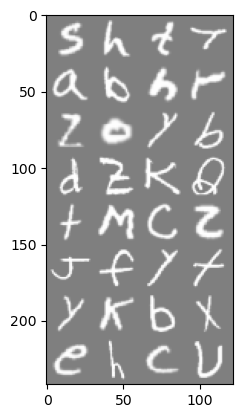

s     a     z     d     t     j     y     e     h     b     o     z     m     f     k     h     t     h     y     k     c     y     b     c     t     r     b     q     z     t     x     u    


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{train_set.classes[labels[j]]:5s}' for j in range(batch_size)))

### **Clasificando con una red densa**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 26)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
net = DenseNet()
net.to(device)

DenseNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=26, bias=True)
)

Definimos la función de pérdida y el *optimizador*.

In [ ]:
import torch.optim as optim

In [ ]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

Entrenamos.

In [ ]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) - 1
        # Restamos 1 para que las clases vayan de 0 a 25, en vez de 1 a 26.

        optimizer.zero_grad() # Reiniciamos los gradientes.

        outputs = net(inputs) # Hacemos la pasada forward.
        loss = criterion(outputs, labels) # Calculamos la pérdida.
        loss.backward() # Hacemos la pasada backward.
        optimizer.step() # Actualizamos los pesos.

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss / total

    # Veamos en validación.
    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad(): # Esta parte es sólo validación, no requiere entrenar, por lo que no calculamos gradientes.
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device) - 1
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # La ganadora es la que tiene mayor valor.
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1} finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

print('Finished training.')

Epoch 1 finished. Train accuracy: 71.14%. Validation accuracy: 85.62%.
Epoch 2 finished. Train accuracy: 87.77%. Validation accuracy: 88.17%.
Finished training.


Ahora, veamos el *accuracy* en el conjunto de test.

Test accuracy: 88.07%.
Predicted:  a     a     c     q     a    
Ground truth:  a     a     a     a     a    


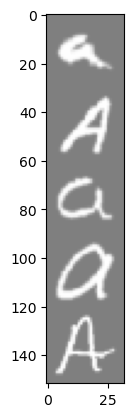

In [ ]:
# Calculamos el accuracy para todo el conjunto de test.
correct = 0
total = 0

first_predicted = None
first_labels = None
first_images = None

with torch.no_grad(): # No necesitamos calcular gradientes.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) - 1 # Recordar restar 1 a las etiquetas.
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        if first_predicted is None:
            first_predicted = predicted
            first_labels = labels
            first_images = images
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Test accuracy: {accuracy:.2f}%.')

print('Predicted: ', ' '.join(f'{test_set.classes[first_predicted[j] + 1]:5s}' for j in range(5)))
print('Ground truth: ', ' '.join(f'{test_set.classes[first_labels[j] + 1]:5s}' for j in range(5)))

# Lo vemos sólo para las primeras 5 imágenes.
imshow(torchvision.utils.make_grid(first_images[:5]))

### **Probemos ahora con capas convolucionales**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,   # 1 canal de entrada.
                               out_channels = 32, # 32 canales de salida.
                               kernel_size = 3,   # Kernel 3x3.
                               stride = 1,        # Pasos de 1.
                               padding = 1)       # Padding de 1 para mantener el tamaño.
        self.conv2 = nn.Conv2d(32, 64,
                               kernel_size = 3, stride = 1, padding = 1)
        self.fc1 = nn.Linear(64 * 7 * 7,
                             # 64 canales de 7x7 pues a la salida de cada capa
                             # convolucional se le aplica un maxpool de 2x2.
                             128)
        self.fc2 = nn.Linear(128, 26) # 26 clases para EMNIST letters.

    def forward(self, x):
        x = nn.LeakyReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
        x = nn.LeakyReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
        x = torch.flatten(x, 1)
        x = nn.LeakyReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
net = CNN()
net.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

Definimos la función de pérdida y el optimizador.

In [ ]:
learning_rate = 0.01
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

Entrenamos.

In [ ]:
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) - 1

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total
    running_loss = running_loss/total

    val_correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device) - 1
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_accuracy = 100 * val_correct / total
    val_loss = val_loss / total

    print(f'Epoch {epoch + 1} finished. Train accuracy: {train_accuracy:.2f}%. Validation accuracy: {val_accuracy:.2f}%.')

print('Finished training.')

Epoch 1 finished. Train accuracy: 82.41%. Validation accuracy: 90.04%.
Epoch 2 finished. Train accuracy: 91.76%. Validation accuracy: 91.64%.
Finished training.


Ahora, veamos el accuracy en el conjunto de test.

Test accuracy: 91.85%.
Predicted:  a     a     a     a     a    
Ground truth:  a     a     a     a     a    


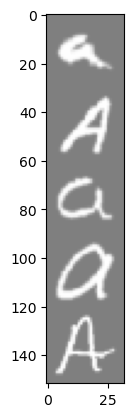

In [ ]:
correct = 0
total = 0

first_predicted = None
first_labels = None
first_images = None

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) - 1
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        if first_predicted is None:
            first_predicted = predicted
            first_labels = labels
            first_images = images
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Test accuracy: {accuracy:.2f}%.')

print('Predicted: ', ' '.join(f'{test_set.classes[first_predicted[j] + 1]:5s}' for j in range(5)))
print('Ground truth: ', ' '.join(f'{test_set.classes[first_labels[j] + 1]:5s}' for j in range(5)))

imshow(torchvision.utils.make_grid(first_images[:5]))